In [55]:
import numpy as np
import pandas as pd
import multiprocessing

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


multiprocessing.set_start_method('spawn', force=True)


./data\cidds-001-externalserver.parquet
./data\cidds-001-openstack.parquet
./data\cidds-002.parquet


In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score, auc, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from fastcore.basics import *
from fastcore.parallel import *
from os import cpu_count
import seaborn as sns
import matplotlib.pyplot as plt

In [57]:
df = pd.concat(objs=[
    pd.read_parquet('./data\cidds-001-openstack.parquet'),
    pd.read_parquet('./data\cidds-001-externalserver.parquet'),
    pd.read_parquet('./data\cidds-002.parquet')
], copy=False, sort=False, ignore_index=True)
df.shape

<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
C:\Users\arman\AppData\Local\Temp\ipykernel_23876\1516442451.py:2: SyntaxWarning: invalid escape sequence '\c'
  pd.read_parquet('./data\cidds-001-openstack.parquet'),
C:\Users\arman\AppData\Local\Temp\ipykernel_23876\1516442451.py:3: SyntaxWarning: invalid escape sequence '\c'
  pd.read_parquet('./data\cidds-001-externalserver.parquet'),
C:\Users\arman\AppData\Local\Temp\ipykernel_23876\1516442451.py:4: SyntaxWarning: invalid escape sequence '\c'
  pd.read_parquet('./data\cidds-002.parquet')


(7010317, 15)

In [58]:
df.columns

Index(['duration', 'proto', 'packets', 'bytes', 'flows', 'tcp_urg', 'tcp_ack',
       'tcp_psh', 'tcp_rst', 'tcp_syn', 'tcp_fin', 'tos', 'label',
       'attack_type', 'attack_id'],
      dtype='object')

In [59]:
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)
df.dropna(inplace=True)
df.shape

(7010317, 15)
(6799141, 15)


(6799141, 15)

In [60]:
df = df.drop(columns=['label', 'attack_id'])
df.shape

(6799141, 13)

In [61]:
df['proto'] = df['proto'].astype('object')
df['proto'] = df['proto'].str.strip()
df['proto'] = df['proto'].astype('category')
df['proto'] = df['proto'].cat.codes
df['proto'] = df['proto'].astype(np.int32)

In [62]:
df['attack_type'] = df['attack_type'].astype('object')
df.loc[df['attack_type'] != 'benign', 'attack_type'] = 1
df.loc[df['attack_type'] == 'benign', 'attack_type'] = 0
print(df['attack_type'].value_counts())
df['attack_type'] = df['attack_type'].astype(dtype=np.int32)

attack_type
0    6783437
1      15704
Name: count, dtype: int64


In [63]:
target = 'attack_type'
conts = list(df.columns.difference([target]).values)
len(conts)

12

In [64]:
df_train = df.sample(frac=0.2, replace=False)
df_test = df.drop(index=df_train.index)
df_train.shape, df_test.shape

((1359828, 13), (5439313, 13))

In [65]:
df_train.groupby('attack_type')['tcp_ack'].value_counts()

attack_type  tcp_ack
0            1          1344200
             0            12508
1            1             2142
             0              978
Name: count, dtype: int64

In [66]:
df_train.groupby('attack_type')['duration'].value_counts()

attack_type  duration  
0            0.000000      6499
             0.070000      3285
             0.064000      3196
             0.072000      3179
             0.052000      3169
                           ... 
1            134.593994       1
             134.641006       1
             136.231003       1
             166.710999       1
             243.895004       1
Name: count, Length: 29092, dtype: int64

In [67]:
def xs_y(df_, targ): 
    if not isinstance(targ, list):
        xs = df_[df_.columns.difference([targ])].copy()
    else:
        xs = df_[df_.columns.difference(targ)].copy()
    y = df_[targ].copy()
    return xs, y

In [68]:
X_train, y_train = xs_y(df_train, targ=target)
X_test, y_test = xs_y(df_test, targ=target)

In [69]:
def evaluate_one_feature(feature, metric=roc_auc_score):    
    # Treinar o modelo Decision Tree
    rootnode = DecisionTreeClassifier(max_depth=3, criterion='gini', class_weight='balanced')    
    rootnode.fit(X_train[feature].array.reshape(-1,1), y_train)    

    # Previsões
    preds = rootnode.predict(X_test[feature].array.reshape(-1,1))
    preds_tr = rootnode.predict(X_train[feature].array.reshape(-1,1))    

    # Métrica
    met = round(metric(y_test, preds), 4)
    if met > 0.5:
        return [feature, met, rootnode, preds, preds_tr]
    else:
        return [feature, met, None, [], []]
    
def evaluate_one_feature_rf(feature, metric=roc_auc_score):   
    # Treinar o modelo Random Florest 
    model = RandomForestClassifier(n_estimators=10, max_depth=3, class_weight='balanced', random_state=42)    
    model.fit(X_train[feature].array.reshape(-1, 1), y_train)    

    # Previsões
    preds = model.predict(X_test[feature].array.reshape(-1, 1))
    preds_tr = model.predict(X_train[feature].array.reshape(-1, 1))    

    # Métrica
    met = round(metric(y_test, preds), 4)
    if met > 0.5:
        return [feature, met, model, preds, preds_tr]
    else:
        return [feature, met, None, [], []]
    
def evaluate_one_feature_xgboost(feature, metric=roc_auc_score):    
    # Treinar o modelo XGBoost
    xgb_model = XGBClassifier(eval_metric='logloss', scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
    xgb_model.fit(X_train[feature].array.reshape(-1, 1), y_train)
    
    # Previsões
    preds = xgb_model.predict(X_test[feature].array.reshape(-1, 1))
    preds_tr = xgb_model.predict(X_train[feature].array.reshape(-1, 1))
    
    # Métrica
    met = round(metric(y_test, preds), 4)
    if met > 0.5:
        return [feature, met, xgb_model, preds, preds_tr]
    else:
        return [feature, met, None, [], []]

In [70]:
results_dst = parallel(f=evaluate_one_feature, items=conts, n_workers=cpu_count(), threadpool=False, progress=True)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck


In [71]:
results_rf = parallel(f=evaluate_one_feature_rf, items=conts, n_workers=cpu_count(), threadpool=False, progress=True)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck


In [72]:
# Executar em paralelo para XGBoost
results_xgb = parallel(f=evaluate_one_feature_xgboost, items=conts, n_workers=cpu_count(), threadpool=False, progress=True)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck


In [73]:
def process_results(results, threshold=0.5):
    """
    Processa os resultados de um modelo, retornando o DataFrame ordenado e as features úteis.

    Args:
        results (list): Lista de resultados no formato [feature, roc_auc_score, fitted_models, predictions, preds_train].
        threshold (float): Valor mínimo para considerar uma feature como útil.

    Returns:
        pd.DataFrame: DataFrame ordenado com os resultados.
        pd.DataFrame: DataFrame com as features úteis (roc_auc_score > threshold).
    """
    result_df = pd.DataFrame(
        data=results, 
        columns=['feature', 'roc_auc_score', 'fitted_models', 'predictions', 'preds_train']
    ).sort_values(by='roc_auc_score', ascending=False)
    
    useful_features = result_df.loc[result_df['roc_auc_score'] > threshold]
    return useful_features

In [74]:
# Decision Tree
useful_features_dst = process_results(results_dst)

# Random Florest
useful_features_rf = process_results(results_rf)

# XGBoost
useful_features_xgb = process_results(results_xgb)

In [75]:
def compute_ensemble_predictions(useful_features, pred_col='predictions', train_col='preds_train'):
    """
    Computa as previsões de ensemble para teste e treino.

    Args:
        useful_features (pd.DataFrame): DataFrame com colunas de previsões e previsões de treino.
        pred_col (str): Nome da coluna que contém as previsões para o conjunto de teste.
        train_col (str): Nome da coluna que contém as previsões para o conjunto de treino.

    Returns:
        tuple: Previsões de ensemble para teste e treino.
    """
    ensemble_preds = np.mean(np.vstack(useful_features[pred_col].to_numpy()), axis=0)
    ensemble_preds_train = np.mean(np.vstack(useful_features[train_col].to_numpy()), axis=0)
    return ensemble_preds, ensemble_preds_train

In [76]:
# Decision Tree
ensemble_preds_dst, ensemble_preds_train_dst = compute_ensemble_predictions(useful_features_dst)

# Random Forest
ensemble_preds_rf, ensemble_preds_train_rf = compute_ensemble_predictions(useful_features_rf)

# XGBoost
ensemble_preds_xgb, ensemble_preds_train_xgb = compute_ensemble_predictions(useful_features_xgb)

In [77]:
def plot_roc_curves(models, y_true):
    """
    Plota as curvas ROC de múltiplos modelos em um único gráfico.

    Args:
        models (dict): Dicionário com o nome do modelo como chave e as previsões como valor.
        y_true (array-like): Valores reais (ground truth).

    Returns:
        dict: Dicionário com os melhores thresholds e AUCs para cada modelo.
    """
    plt.figure(figsize=(10, 8))
    thresholds_and_aucs = {}

    for model_name, predictions in models.items():
        # Calcula os valores de ROC
        fpr, tpr, thresholds = roc_curve(y_true, predictions)
        roc_auc = auc(fpr, tpr)

        # Melhor threshold
        J = tpr - fpr
        ix = np.argmax(J)
        best_thresh = thresholds[ix]
        thresholds_and_aucs[model_name] = {"best_thresh": best_thresh, "roc_auc": roc_auc}

        # Plota a curva ROC
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.4f})")

    # Configurações do gráfico
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
    plt.title('ROC Curves for Models', fontsize=16)
    plt.xlabel('False Positive Rate (FPR)', fontsize=14)
    plt.ylabel('True Positive Rate (TPR)', fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid()
    plt.show()

    return thresholds_and_aucs

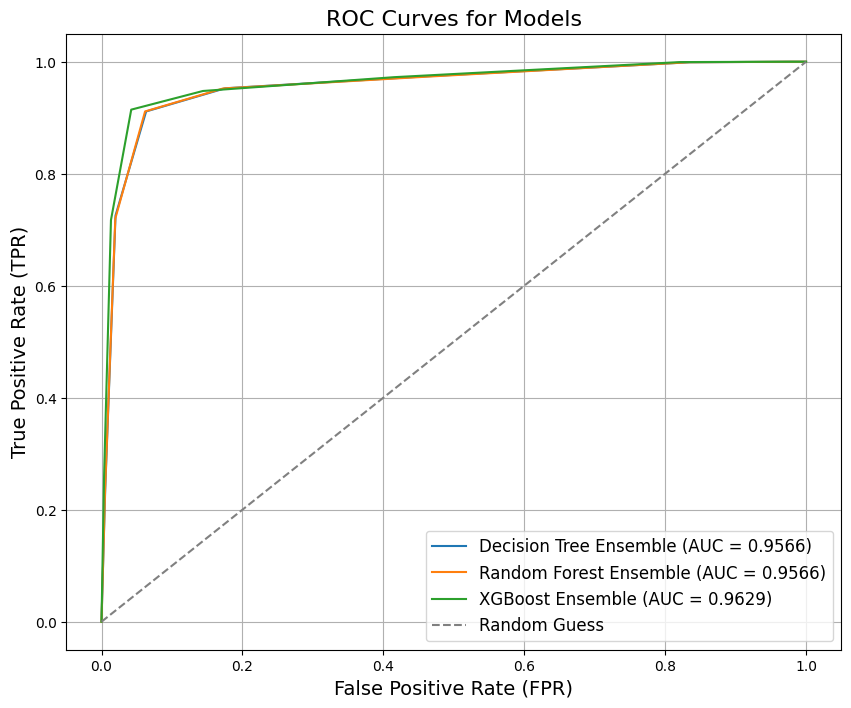

Decision Tree Ensemble: Best Threshold = 0.5000, AUC = 0.9566
Random Forest Ensemble: Best Threshold = 0.5000, AUC = 0.9566
XGBoost Ensemble: Best Threshold = 0.5000, AUC = 0.9629


In [78]:
# Dicionário com os modelos e suas previsões para treino
model_predictions = {
    "Decision Tree Ensemble": ensemble_preds_train_dst,
    "Random Forest Ensemble": ensemble_preds_train_rf,
    "XGBoost Ensemble": ensemble_preds_train_xgb
}

# Plota as curvas ROC para os três modelos
thresholds_and_aucs = plot_roc_curves(model_predictions, y_train)

# Exibe os resultados
for model, metrics in thresholds_and_aucs.items():
    print(f"{model}: Best Threshold = {metrics['best_thresh']:.4f}, AUC = {metrics['roc_auc']:.4f}")


In [79]:
def evaluate_model_metrics(predictions, best_threshold, y_true, model_name="Model"):
    """
    Avalia as métricas de um modelo com base em um conjunto de previsões e um threshold.
    
    Args:
        predictions (array-like): Previsões do modelo.
        best_threshold (float): O threshold ótimo para o modelo.
        y_true (array-like): Verdadeiros rótulos.
        model_name (str): Nome do modelo, como string.
        
    Prints:
        Exibe o Best Threshold, AUC, Precision, Recall e F1-Score.
    """
    print(f"Evaluating {model_name}...")
    print(f"Best threshold: {round(best_threshold, 4)}")
    print(f"The Ensemble {model_name} (simple average)")

    # Calculando as métricas
    auc = round(roc_auc_score(y_true, predictions), 4)
    precision = round(precision_score(y_true, np.where(predictions >= best_threshold, 1, 0)), 4)
    recall = round(recall_score(y_true, np.where(predictions >= best_threshold, 1, 0)), 4)
    f1 = round(f1_score(y_true, np.where(predictions >= best_threshold, 1, 0)), 4)

    # Exibindo os resultados
    print(f"ROC-AUC: {auc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("-" * 40)

# Avaliação dos três modelos

print(thresholds_and_aucs)

# Para o modelo Decision Tree Ensemble
evaluate_model_metrics(ensemble_preds_dst, thresholds_and_aucs['Decision Tree Ensemble']['best_thresh'], y_test, "Ensemble Decision Tree")

# Para o modelo Random Forest Ensemble
evaluate_model_metrics(ensemble_preds_rf, thresholds_and_aucs['Random Forest Ensemble']['best_thresh'], y_test, "Ensemble Random Forest")

# Para o modelo XGBoost Ensemble
evaluate_model_metrics(ensemble_preds_xgb, thresholds_and_aucs['XGBoost Ensemble']['best_thresh'], y_test, "Ensemble XGBoost")


{'Decision Tree Ensemble': {'best_thresh': np.float64(0.5), 'roc_auc': np.float64(0.9566007046808553)}, 'Random Forest Ensemble': {'best_thresh': np.float64(0.5), 'roc_auc': np.float64(0.956599966303238)}, 'XGBoost Ensemble': {'best_thresh': np.float64(0.5), 'roc_auc': np.float64(0.9628935152268656)}}
Evaluating Ensemble Decision Tree...
Best threshold: 0.5
The Ensemble Ensemble Decision Tree (simple average)
ROC-AUC: 0.9573
Precision: 0.0326
Recall: 0.9147
F1 Score: 0.063
----------------------------------------
Evaluating Ensemble Random Forest...
Best threshold: 0.5
The Ensemble Ensemble Random Forest (simple average)
ROC-AUC: 0.9576
Precision: 0.0334
Recall: 0.9143
F1 Score: 0.0644
----------------------------------------
Evaluating Ensemble XGBoost...
Best threshold: 0.5
The Ensemble Ensemble XGBoost (simple average)
ROC-AUC: 0.9633
Precision: 0.048
Recall: 0.9151
F1 Score: 0.0912
----------------------------------------
